In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import pandas
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from tabulate import tabulate
from config import config
from data import data
from calculate_features import all_features

Using TensorFlow backend.


In [3]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description="", label=""): 
    pm.execute_notebook(
        "evaluate-specific-model.ipynb",
        "evaluate-{}-{}-{}-{}.ipynb".format(description, input_form, label, uuid),
        parameters = dict(
            UUID=uuid,
            SELECTIONS=repr(selections),
            TSNE_PERPLEXITY=tsne_perplexity,
        ),
    )
    return "evaluate-{}-{}-{}-{}.ipynb".format(description, input_form, label, uuid)

In [4]:
LABEL_FORMAT = "shrinked"

In [5]:
# Parameters
LABEL_FORMAT = "shrinked"


In [6]:
SHRINKED_UUIDS = [    
    "ce28b91e-b0ef-4e3e-ae59-36cb6e581c6c", # t1
    "9b3d2d62-74df-4e23-ab86-c151f9f79501", # t2
    "75cde760-6a4b-40ea-8a6a-d2f4e67fbe45", # features
]

OUTCOME_UUIDS = [    
    "85e2a7b4-05cc-46d1-98dc-f6addf275516", # t1
    "ef13afa7-55ff-48f3-a7c6-d882307f185b", # t2
    "d5353e6d-be2b-4e65-955d-8191d8ef35b3", # features
]

if LABEL_FORMAT is "shrinked": 
    UUIDS = SHRINKED_UUIDS
else: 
    UUIDS = OUTCOME_UUIDS

SELECTIONS = {
    "85e2a7b4-05cc-46d1-98dc-f6addf275516": {
        #("failure", "failure"): ["1001672204-2"],
        #("failure", "success"): ["1003560165-2"],
        #("success", "success"): ["1004524374-3"],
        #("success", "failure"): [],
    },
}
TSNE_PERPLEXITY = {
    "85e2a7b4-05cc-46d1-98dc-f6addf275516": 10, # t1
    "ef13afa7-55ff-48f3-a7c6-d882307f185b": 5, # t2
    "d5353e6d-be2b-4e65-955d-8191d8ef35b3": 5, # features
    "ce28b91e-b0ef-4e3e-ae59-36cb6e581c6c": 5, # t1
    "9b3d2d62-74df-4e23-ab86-c151f9f79501": 10, # t2
    "75cde760-6a4b-40ea-8a6a-d2f4e67fbe45": 5, # features    
}
MODALITY = {
    "85e2a7b4-05cc-46d1-98dc-f6addf275516": "t1", # t1
    "ef13afa7-55ff-48f3-a7c6-d882307f185b": "t2", # t2
    "d5353e6d-be2b-4e65-955d-8191d8ef35b3": "features", # features
    "ce28b91e-b0ef-4e3e-ae59-36cb6e581c6c": "t1", # t1
    "9b3d2d62-74df-4e23-ab86-c151f9f79501": "t2", # t2
    "75cde760-6a4b-40ea-8a6a-d2f4e67fbe45": "features", # features 
}

In [7]:
completed_notebooks = list()
modality_by_notebook = dict()

In [8]:
for uuid in UUIDS: 
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid, 5), result.input_form, result.description, result.label_form)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY.get(uuid)

Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-t1-shrunk-ce28b91e-b0ef-4e3e-ae59-36cb6e581c6c.ipynb
100%|██████████| 63/63 [02:57<00:00,  4.20it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-t2-shrunk-9b3d2d62-74df-4e23-ab86-c151f9f79501.ipynb
100%|██████████| 63/63 [02:13<00:00,  4.28it/s]
Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-features-shrunk-75cde760-6a4b-40ea-8a6a-d2f4e67fbe45.ipynb
100%|██████████| 63/63 [02:27<00:00,  8.35it/s]


In [9]:
pm.execute_notebook(
    "evaluate-ensemble.ipynb",
    "evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)),
    parameters = dict(
        MODELS=UUIDS,
        LABEL_FORMAT=LABEL_FORMAT,
    ),
)
completed_notebooks.append("evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)))
modality_by_notebook["evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

Input Notebook:  evaluate-ensemble.ipynb
Output Notebook: evaluate-ensemble-ce28b91e-b0ef-4e3e-ae59-36cb6e581c6c-9b3d2d62-74df-4e23-ab86-c151f9f79501-75cde760-6a4b-40ea-8a6a-d2f4e67fbe45.ipynb
100%|██████████| 45/45 [23:01<00:00,  1.02it/s]   


In [10]:
def get_notebook_output(notebook, name): 
    return notebook.dataframe[notebook.dataframe.name==name].value.tolist()[0]

In [11]:
train = dict()
validation = dict()
test = dict()
for notebook in completed_notebooks: 
    nb = pm.read_notebook(notebook)
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")

In [12]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
train_set, validation_set, test_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

 23%|██▎       | 33/146 [00:03<00:13,  8.48it/s]


################################################################################
Exception occured for: patient                              1002919100
outcome                                 failure
outcome3                                failure
premenorrhagia                             True
prebulk                                   False
preg                                          0
surg                                          0
followup                              0.0387147
followup_raw                                100
post-embolization-symptoms-binary         False
shrunk                                     True
pre_volume                           0.00565114
absolute_delta                         -7715.04
relative_change                       -0.343831
Name: 1002919100-2, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/uae/data/preprocessed/1002919100-2-T1C-imagingVolume.nrrd'


 73%|███████▎  | 107/146 [00:14<00:07,  5.43it/s]


################################################################################
Exception occured for: patient                              1002919100
outcome                                 failure
outcome3                                failure
premenorrhagia                             True
prebulk                                   False
preg                                          0
surg                                          0
followup                              0.0387147
followup_raw                                100
post-embolization-symptoms-binary         False
shrunk                                     True
pre_volume                           0.00644993
absolute_delta                         -11548.8
relative_change                       -0.453135
Name: 1002919100-0, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/uae/data/preprocessed/1002919100-0-T1C-imagingVolume.nrrd'


100%|██████████| 73/73 [00:12<00:00,  5.86it/s]


In [17]:
MODALITIES = [
    "features",     
    "t1", 
    "t2", 
    "ensemble", 
]

def get_pr_data_for_modality(dataset): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f})".format(modality, pr_auc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f})".format(modality, pr_auc)})
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[]):
    results, auc, points = get_pr_data_for_modality(dataset)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {}".format(i + 1), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers={ "Expert 1": "o", "Expert 2": "v", "Expert 3": "s", "Expert 4": "P"},            
            palette={ "Expert 1": "black", "Expert 2": "black", "Expert 3": "black", "Expert 4": "black" },
            ax=ax,
        )
    ax.set_ylim(0.5, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f})".format(modality, roc_auc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f})".format(modality, roc_auc)})
    return results, roc_auc, []
        
def plot_multiple_roc_curve(dataset, experts=[]):
    results, auc, points = get_roc_data_for_modality(dataset)
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            points.append({
                "fpr": stats["FPR"][1],
                "tpr": stats["TPR"][1],
                "experts": "Expert {}".format(i + 1), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="fpr",
        y="tpr",
        hue="modality",
        ax=ax,
        err_style=None,
    )
    if points:     
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="fpr",
            y="tpr",
            hue="experts",
            style="experts",            
            ax=ax,
            markers={ "Expert 1": "o", "Expert 2": "v", "Expert 3": "s", "Expert 4": "P"},            
            palette={ "Expert 1": "black", "Expert 2": "black", "Expert 3": "black", "Expert 4": "black" },
        )
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_statistics(dataset, experts=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        total = len(labels)
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        low, high = adjusted_wald(correct/total, total)
        low = round(low, 5)
        high = round(high, 5)
        d = {
            "wald": str(low) + ' , ' + str(high),
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]
        del d["TPR"]
        del d["TNR"]        
        del d["FPR"]
        del d["FNR"]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["t1-labels"]
        predictions = expert
        correct = sum([ labels[i] == p for i, p in enumerate(predictions) ])
        total = len(labels)
        f1 = f1_score(labels, predictions)
        low, high = adjusted_wald(correct/total, total)
        low = round(low, 5)
        high = round(high, 5)
        d = {
            "wald": str(low) + ' , ' + str(high),
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]         
        del d["TPR"]
        del d["TNR"]                
        del d["FPR"]
        del d["FNR"]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=["expert-0-outcome", "expert-2-outcome"]): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names: 
            f = features.get(n, None)
            if f is None: 
                print("error, cannot find {}".format(n))
                expert_results.append(-1)
                continue 
            if (f.get(e) == ''):
                expert_results.append(-1)
                print(f)
                print(e)
            else:   
                expert_results.append(int(f.get(e, -1)))
        result.append(expert_results)
    return result

In [18]:
import math
def adjusted_wald(p, n, z=1.96): 
    p_adj = (n * p + (z**2)/2)/(n+z**2)
    n_adj = n + z**2
    span = z * math.sqrt(p_adj*(1-p_adj)/n_adj)
    return p_adj - span, p_adj + span

In [19]:
#expert_features = all_features(files = [config.EXPERTS])
df = get_statistics(train)#, get_experts_for_names(expert_features, train_set.names, experts=["expert-0-volume", "expert-2-volume"]))
print()
print("##### Train")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(validation)#, get_experts_for_names(expert_features, validation_set.names, experts=["expert-0-volume", "expert-2-volume"]))
print()
print("##### Validation")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(test)#, get_experts_for_names(expert_features, test_set.names, experts=["expert-0-volume", "expert-2-volume"]))
print()
print("##### Test")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))


##### Train

| Modality   | wald              |   F1 Score |   ROC AUC |   PR AUC |   Acc |   PPV |   NPV |     FDR |    AM |    GM |
|:-----------|:------------------|-----------:|----------:|---------:|------:|------:|------:|--------:|------:|------:|
| Clinical   | 0.71366 , 0.78844 |      0.857 |     0.494 |    0.782 | 0.753 | 0.767 | 0.353 | 0.233   | 0.511 | 0.220 |
| T1         | 0.98782 , 1.00082 |      0.999 |     1.00  |    1.00  | 0.998 | 0.997 | 1.00  | 0.00256 | 0.996 | 0.996 |
| T2         | 0.95887 , 0.98695 |      0.985 |     0.997 |    0.999 | 0.976 | 0.970 | 1.00  | 0.0299  | 0.950 | 0.949 |
| Ensemble   | 0.98782 , 1.00082 |      0.999 |     0.996 |    0.999 | 0.998 | 0.997 | 1.00  | 0.00256 | 0.996 | 0.996 |

##### Validation

| Modality   | wald              |   F1 Score |   ROC AUC |   PR AUC |   Acc |   PPV |   NPV |   FDR |    AM |    GM |
|:-----------|:------------------|-----------:|----------:|---------:|------:|------:|------:|------:|------:|------:|
| C

/home/user1/intrepidlemon/deep-mri/evaluate.py:338: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
/home/user1/intrepidlemon/deep-mri/evaluate.py:340: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
/home/user1/intrepidlemon/deep-mri/evaluate.py:346: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


features 510 510 510
t1 510 510 510
t2 510 510 510
ensemble 510 510 510
features 144 144 144
t1 144 144 144
t2 144 144 144
ensemble 144 144 144
features 73 73 73
t1 73 73 73
t2 73 73 73
ensemble 73 73 73


/home/user1/intrepidlemon/deep-mri/evaluate.py:338: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
/home/user1/intrepidlemon/deep-mri/evaluate.py:340: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN/(TN+FN)
/home/user1/intrepidlemon/deep-mri/evaluate.py:346: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


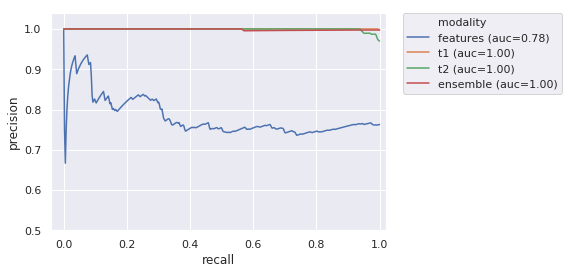

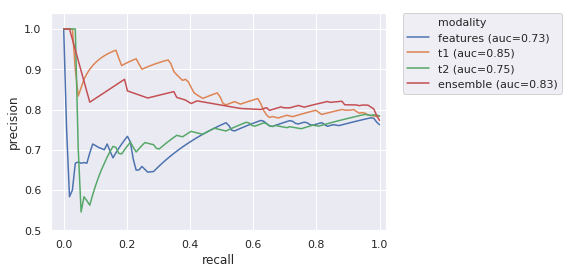

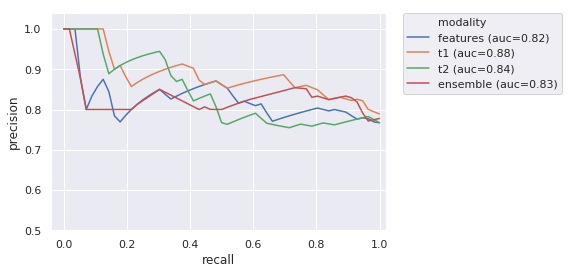

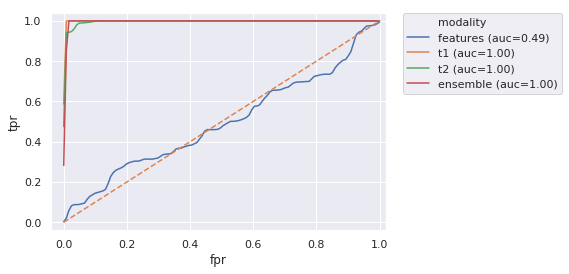

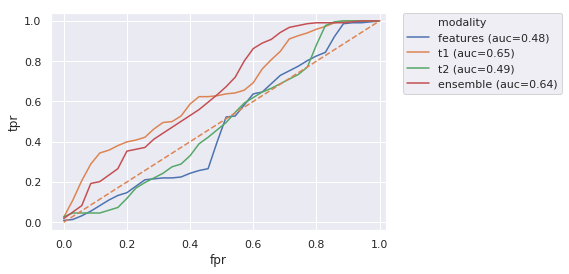

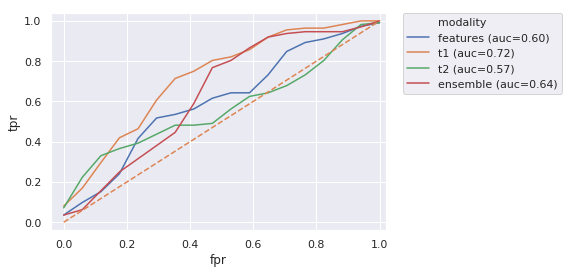

In [20]:
fig = plot_multiple_precision_recall(train)#, experts=get_experts_for_names(expert_features, train_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-train-precision-recall.svg".format(LABEL_FORMAT), bbox_inches = "tight")
fig = plot_multiple_precision_recall(validation)#, experts=get_experts_for_names(expert_features, validation_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-validation-precision-recall.svg".format(LABEL_FORMAT), bbox_inches = "tight")
fig = plot_multiple_precision_recall(test)#, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-test-precision-recall.svg".format(LABEL_FORMAT), bbox_inches = "tight")
fig = plot_multiple_roc_curve(train)#, experts=get_experts_for_names(expert_features, train_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-train-roc.svg".format(LABEL_FORMAT), bbox_inches = "tight")
fig = plot_multiple_roc_curve(validation)#, experts=get_experts_for_names(expert_features, validation_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-validation-roc.svg".format(LABEL_FORMAT), bbox_inches = "tight")
fig = plot_multiple_roc_curve(test)#, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert-0-volume", "expert-2-volume"]))
fig.savefig("figures/combined-{}-test-roc.svg".format(LABEL_FORMAT), bbox_inches = "tight")